In [1]:
!pip install tqdm

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from PIL import Image
import numpy as np
import time
import zipfile
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Mission1-1.

## training_image data 통계

In [4]:
# 이미지가 저장된 경로 설정
image_dir = '/content/drive/MyDrive/datahighfive/mission_data/training_image'   # train

image_dir2 = '/content/drive/MyDrive/datahighfive/mission_data/validation_image'    # val

In [5]:
import os
import pandas as pd
from collections import defaultdict


# 성별 및 스타일 정보를 저장할 딕셔너리
gender_style_count = defaultdict(int)

# 파일명을 기준으로 성별 & 스타일 정보를 추출하고 카운팅
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):
        # 파일명을 '_'로 분리
        parts = filename.split('_')

        # 성별은 마지막 부분, 스타일은 세 번째 부분
        gender = parts[-1][0]  # W 또는 M
        style = parts[3]  # popart, sportivecasual 등

        # 성별과 스타일을 기반으로 카운팅
        key = (gender, style)
        gender_style_count[key] += 1

# 딕셔너리를 데이터프레임으로 변환
train_df = pd.DataFrame(gender_style_count.items(), columns=['Gender_Style', 'Count'])

# 성별과 스타일을 개별 열로 분리
train_df[['Gender', 'Style']] = pd.DataFrame(train_df['Gender_Style'].tolist(), index=train_df.index)

# 필요 없는 Gender_Style 열 제거
train_df = train_df.drop(columns=['Gender_Style'])

# 열 순서 정리 (Gender, Style, Count)
train_df = train_df[['Gender', 'Style', 'Count']]

# 성별을 'W' -> 'M' 순으로 정렬하고, 이미지 수가 많은 순으로 정렬
train_df = train_df.sort_values(by=['Gender', 'Count'], ascending=[False, False])


# 결과 출력
train_df = train_df.reset_index(drop=True)
train_df

,Gender,Style,Count
0,W,sportivecasual,157
1,W,feminine,154
2,W,normcore,153
3,W,minimal,139
4,W,powersuit,120
5,W,bodyconscious,95
6,W,hippie,91
7,W,kitsch,91
8,W,oriental,78
9,W,genderless,77


In [6]:
# prompt: train_df count 컬럼 수를 모두 더하는 코드

total_count = train_df['Count'].sum()
print(f'train_total_count: {total_count}')

# prompt: df에서 Gender 컬럼의 값이 W, M인 것들만 Count 컬럼의 값을 더하는 코드

female_count = train_df[train_df['Gender'] == 'W']['Count'].sum()
male_count = train_df[train_df['Gender'] == 'M']['Count'].sum()
print(f'female_count: {female_count}, male_count: {male_count}')

train_total_count: 4070
female_count: 1822, male_count: 2248


## validation_image data 통계

In [7]:
import os
import pandas as pd
from collections import defaultdict

# 성별 및 스타일 정보를 저장할 딕셔너리
gender_style_count = defaultdict(int)

# 파일명을 기준으로 성별 & 스타일 정보를 추출하고 카운팅
for filename in os.listdir(image_dir2):
    if filename.endswith('.jpg'):
        # 파일명을 '_'로 분리
        parts = filename.split('_')

        # 성별은 마지막 부분, 스타일은 세 번째 부분
        gender = parts[-1][0]  # W 또는 M
        style = parts[3]  # popart, sportivecasual 등

        # 성별과 스타일을 기반으로 카운팅
        key = (gender, style)
        gender_style_count[key] += 1

# 딕셔너리를 데이터프레임으로 변환
val_df = pd.DataFrame(gender_style_count.items(), columns=['Gender_Style', 'Count'])

# 성별과 스타일을 개별 열로 분리
val_df[['Gender', 'Style']] = pd.DataFrame(val_df['Gender_Style'].tolist(), index=val_df.index)

# 필요 없는 Gender_Style 열 제거
val_df = val_df.drop(columns=['Gender_Style'])

# 열 순서 정리 (Gender, Style, Count)
val_df = val_df[['Gender', 'Style', 'Count']]

# 성별을 'W' -> 'M' 순으로 정렬하고, 이미지 수가 많은 순으로 정렬
val_df = val_df.sort_values(by=['Gender', 'Count'], ascending=[False, False])

# 결과 출력
val_df = val_df.reset_index(drop=True)
val_df

,Gender,Style,Count
0,W,sportivecasual,48
1,W,feminine,44
2,W,minimal,35
3,W,powersuit,34
4,W,bodyconscious,23
5,W,kitsch,22
6,W,classic,22
7,W,normcore,20
8,W,cityglam,18
9,W,oriental,18


In [8]:
# prompt: val_df count 컬럼 수를 모두 더하는 코드

total_count = val_df['Count'].sum()
print(f'val_total_count: {total_count}')

# prompt: df에서 Gender 컬럼의 값이 W, M인 것들만 Count 컬럼의 값을 더하는 코드

female_count = val_df[val_df['Gender'] == 'W']['Count'].sum()
male_count = val_df[val_df['Gender'] == 'M']['Count'].sum()
print(f'female_count: {female_count}, male_count: {male_count}')

val_total_count: 951
female_count: 426, male_count: 525


# Mission1-2.

클래스별 이미지 확인

Total classes (W): 23 -> ['sportivecasual', 'hiphop', 'oriental', 'normcore', 'lingerie', 'minimal', 'powersuit', 'space', 'ecology', 'disco', 'hippie', 'genderless', 'feminine', 'cityglam', 'punk', 'classic', 'kitsch', 'popart', 'bodyconscious', 'lounge', 'athleisure', 'grunge', 'military']


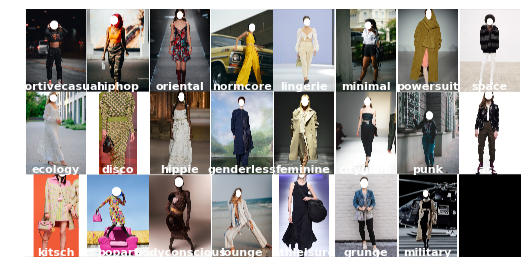

In [9]:
import os
import glob
import random
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch

# 클래스와 성별을 구분하는 함수
def get_class_and_gender(filename):
    # 파일명에서 성별(M/W) 및 클래스 추출
    parts = os.path.basename(filename).split('_')
    class_name = parts[-2]  # 클래스명 추출
    gender = parts[-1][0]   # 'W' 또는 'M' 추출
    return class_name, gender

# 이미지 파일을 탐색하여 성별 및 클래스별로 분류
def classify_images(image_dir):
    image_paths = glob.glob(os.path.join(image_dir, '*.jpg'))  # 모든 이미지 파일 가져오기
    class_gender_dict = {'M': {}, 'W': {}}  # 남자(M)와 여자(W)로 구분
    for img_path in image_paths:
        class_name, gender = get_class_and_gender(img_path)
        if class_name not in class_gender_dict[gender]:
            class_gender_dict[gender][class_name] = []
        class_gender_dict[gender][class_name].append(img_path)
    return class_gender_dict

# 클래스별 대표 이미지를 랜덤으로 하나씩 선택
def get_random_class_samples(class_gender_dict, gender, num_classes=31):
    samples = []
    classes = list(class_gender_dict[gender].keys())  # 해당 성별의 모든 클래스 목록
    print(f"Total classes ({gender}): {len(classes)} -> {classes}")

    for class_name in classes:
        if len(samples) >= num_classes:
            break
        class_images = class_gender_dict[gender][class_name]
        random_image = random.choice(class_images)  # 각 클래스에서 랜덤 이미지 선택
        samples.append((random_image, class_name))

    return samples

# 이미지를 시각화하는 함수
def imshow(img_paths, labels):
    images = []
    for img_path in img_paths:
        img = plt.imread(img_path)  # 이미지 읽기
        img = torch.tensor(img).permute(2, 0, 1)  # (H, W, C) -> (C, H, W)
        images.append(img)

    # 이미지를 그리드로 만들기
    grid = torchvision.utils.make_grid(images, nrow=8, padding=2)
    npimg = grid.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # 이미지 (C, H, W) -> (H, W, C)
    plt.axis('off')

    # 각 이미지에 해당하는 라벨을 그리드 내의 적절한 위치에 표시 (아래쪽)
    nrow = 8  # 그리드의 열 수
    img_per_row = len(labels) // nrow + (len(labels) % nrow > 0)
    grid_height = npimg.shape[1] / img_per_row
    grid_width = npimg.shape[2] / nrow

    for i, label in enumerate(labels):
        # 이미지의 아래쪽 중앙에 라벨 배치
        x = (i % nrow) * grid_width + grid_width / 2
        y = (i // nrow + 1) * grid_height - 10
        plt.text(x, y, label, ha='center', va='bottom', fontsize=8, color='white', weight='bold')

    plt.show()

# 이미지 분류 수행
class_gender_dict = classify_images(image_dir)

# 원하는 성별 선택 (예: 'W' for 여성, 'M' for 남성)
gender = 'W'  # 'M' 또는 'W'

# 각 클래스별로 1개의 이미지를 랜덤으로 선택
random_class_samples = get_random_class_samples(class_gender_dict, gender)

# 선택된 이미지 경로와 클래스 이름을 분리
image_paths, class_labels = zip(*random_class_samples)

# 시각화
imshow(image_paths, class_labels)

Total classes (M): 8 -> ['metrosexual', 'hippie', 'normcore', 'bold', 'sportivecasual', 'hiphop', 'mods', 'ivy']


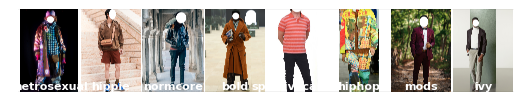

In [10]:
# 원하는 성별 선택 (예: 'W' for 여성, 'M' for 남성)
gender = 'M'  # 'M' 또는 'W'

# 각 클래스별로 1개의 이미지를 랜덤으로 선택
random_class_samples = get_random_class_samples(class_gender_dict, gender)

# 선택된 이미지 경로와 클래스 이름을 분리
image_paths, class_labels = zip(*random_class_samples)

# 시각화
imshow(image_paths, class_labels)

In [11]:
from PIL import Image
import os

# 이미지 파일 경로 설정 (예시: 첫 번째 이미지 경로)
image_path = f'{image_dir}/T_00253_60_popart_W.jpg'

# 이미지 열기
img = Image.open(image_path)

# 이미지 크기 확인
print(f"Image size (width, height): {img.size}")

# 이미지 모드 확인 (RGB, Grayscale 등)
print(f"Image mode: {img.mode}")

# 이미지 파일의 타입 확인
print(f"Image format: {img.format}")


Image size (width, height): (3000, 4000)
Image mode: RGB
Image format: JPEG
